In [1]:
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
import drjit as dr
import trimesh
import polyscope as ps

mi.set_variant("llvm_ad_rgb")

In [2]:
MESH = "figures/UNSAMPLED/unconverged_64764_b32_nearsample/DCCVT_0_final_intDCCVT_cvt100_sdfsmooth100.obj"
# MESH = "figures/UNSAMPLED/unconverged_64764_b32_nearsample/marching_tetrahedra_0_final_MT_cvt0_sdfsmooth0.obj"
# MESH_TRUE = "mesh/thingi32/64764.obj"
MESH_TRUE = "mesh/thingi32/441708.obj"

CAMERA_CONFIG = {
    "fov": 30,
    "cam_position": np.array([-1.0, -2.0, 0.0]),
    "target": np.array([0, 0, 0.0])
}
IMG_RES = (800, 600, 3)
IMG_RES_SAMPLED = (256, 256, 3)

def rescale_hotspot(mesh_path):

    mesh = trimesh.load(mesh_path)

    # # Normalize mesh (centered and scaled uniformly)
    # bbox = mesh.bounds
    # center = mesh.centroid
    # scale = np.linalg.norm(bbox[1] - bbox[0])
    # mesh.apply_translation(-center)
    # mesh.apply_scale(1.0 / scale)

    # # Export normalized mesh
    # mesh.export(mesh_path.replace(".obj", ".obj"))

    points_gt, _ = trimesh.sample.sample_surface(mesh, (32**2)*150)
    # center and scale point cloud
    cp = points_gt.mean(axis=0)
    points = points_gt - cp[None, :]
    scale = np.percentile(np.linalg.norm(points, axis=-1), 70) / 0.45
    scale = max(scale, np.abs(points).max())

    cp = cp.astype(np.float32)
    return scale, np.array([cp[0], cp[1], cp[2]])

Scale: 0.6496275261532374, Center: [-2.6333708e-04  2.0288359e-04 -5.4757849e-05]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.54794943..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.36179572..1.0000001].


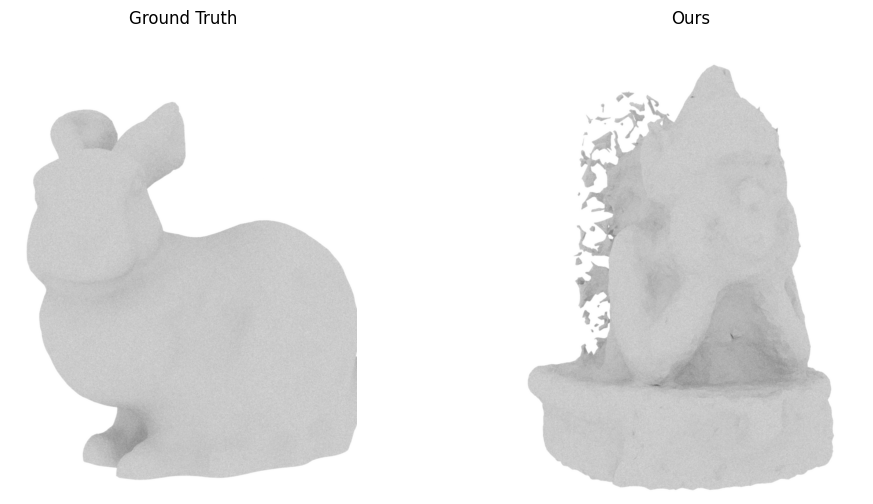

In [3]:
def create_scene(mesh, camera_config, img_res,
            translate=[0, 0, 0], scale=1):
    # Create simple scene
    scene_dict = {
        "type": "scene",
        "integrator": {
            "type": "path"
        },
        "sensor": {
            "type": "perspective",
            "fov": camera_config["fov"],
            "fov_axis" : "y",
            "to_world": mi.ScalarTransform4f.look_at(
                camera_config["cam_position"],
                camera_config["target"],
                np.array([0, 0, 1])  # Up vector
            ),
            "sampler": {
                "type": "independent"
            },
            "film": {
                "type": "hdrfilm",
                "width": img_res[1],
                "height": img_res[0]
            }
        },
        "mesh": {
            "type": "obj",
            "filename": mesh,
            "face_normals": True,
            "bsdf": {
                "type" : "twosided",
                "bsdf" : {
                    "type": "diffuse",
                    "reflectance": {
                        "type": "rgb",
                        "value": [0.8, 0.8, 0.8]
                    }
                }
            },
            # If we want to replicate the polyscope view
            "to_world": mi.ScalarTransform4f.translate(translate) @ mi.ScalarTransform4f.scale([scale, scale, scale])
        },
        "constant" : {
            "type" : "constant",
            "radiance" : 1.0
        }
    }
    scene = mi.load_dict(scene_dict)
    return scene

def render_scene(scene, spp=64, sensor=None):
    if sensor == None:
        im = mi.render(scene, spp=spp)
    else:
        im = mi.render(scene, spp=spp, sensor=sensor)
    im = mi.TensorXf(im.array, shape=IMG_RES)
    return im

# Render scene
scale, cp = rescale_hotspot(MESH_TRUE)
print(f"Scale: {scale}, Center: {cp}")
cp = np.array([0, 0, -0.1])
scene_gt = create_scene(MESH_TRUE, CAMERA_CONFIG, IMG_RES, translate=cp, scale=1./scale)
scene_ours = create_scene(MESH, CAMERA_CONFIG, IMG_RES, translate=cp)
im_gt = render_scene(scene_gt)
im_ours = render_scene(scene_ours)

# Show the two images on the side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_gt); plt.axis('off');
plt.title("Ground Truth")
plt.subplot(1, 2, 2)
plt.imshow(im_ours); plt.axis('off');
plt.title("Ours")
plt.show()


max extend:  0.944090723991394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4906734..0.50344706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41914663..0.5038279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48004818..0.50374824].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4802769..0.50398403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48007995..0.44068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48004815..0.51556396].


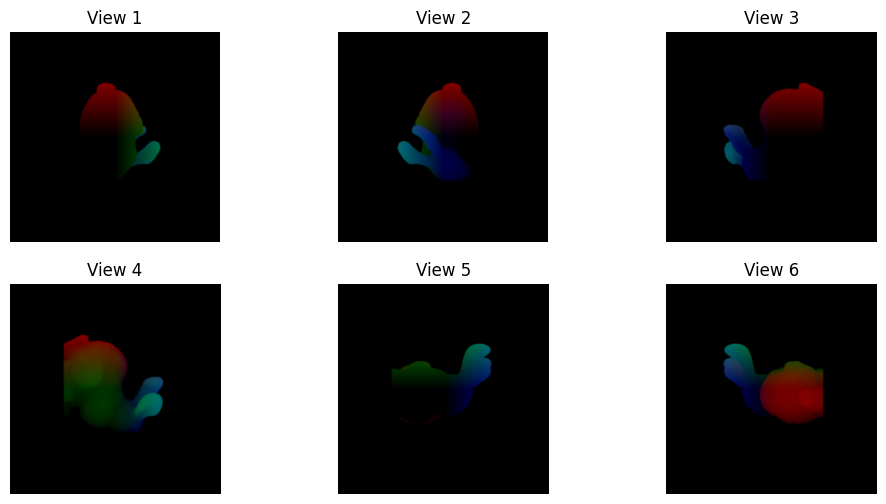

In [ ]:
# Compute bounding box 
#params_gt = mi.traverse(scene_gt)
#print(params_gt)
mesh_gt = scene_gt.shapes()[0]
mesh_aabb = mesh_gt.bbox()

max_extend = dr.max(mesh_aabb.extents())
print("max extend: ", max_extend)

# Create sensor orthogonal view Z+
def create_orthographic(position, img_res):
    up=[1,0,0]
    if position[2] == 0 and position[1] == 0:
        up = [0, 1, 0]

    sensor = mi.load_dict({
        "type": "orthographic",
        "to_world": mi.ScalarTransform4f.look_at(position, [0,0,0], up),
        "sampler": {
            "type": "independent"
        },
        "film": {
            "type": "hdrfilm",
            "width": img_res[1],
            "height": img_res[0]
        }
    })
    return sensor

# Create all 6 positions 
cam_positions = [
    [0, 0, -2 * max_extend ], 
    [0, 0, 2 * max_extend],
    [0, -2 * max_extend, 0],
    [0, 2 * max_extend, 0],
    [-2 * max_extend, 0, 0],
    [2 * max_extend, 0, 0]
]

integrator = mi.load_dict({
    'type': 'aov',
    'aovs': 'p:position,d:depth',
    'my_image': {
        'type': 'direct',
    }
})

positions = []
depths = []
imgs = []
for pos in cam_positions:
    sensor = create_orthographic(pos, IMG_RES_SAMPLED)
    im = mi.render(scene_gt, sensor=sensor, spp=16, integrator=integrator)
    image = im[:, :, :3]
    position = im[:, :, 3:6]
    depth = im[:, :, 6:7]
    positions.append(position)
    depths.append(depth)
    image = mi.TensorXf(position.array, shape=IMG_RES_SAMPLED)
    imgs.append(image)

# Show all images
plt.figure(figsize=(12, 6))
for i, im in enumerate(imgs):
    plt.subplot(2, 3, i + 1)
    plt.imshow(im); plt.axis('off');
    plt.title(f"View {i + 1}")
plt.show()

# Mask all pixels
positions = [mi.TensorXf(p.array, shape=IMG_RES_SAMPLED).numpy() for p in positions]
positions = [np.reshape(p, (IMG_RES_SAMPLED[0] * IMG_RES_SAMPLED[1], 3)) for p in positions]
positions = [p[np.linalg.norm(p, axis=-1) > 0.1] for p in positions]
print(positions)


# Show inside polyscope
ps.init()
for i, pos in enumerate(positions):
    ps.register_point_cloud(f"points_{i}", pos, radius=0.001)
ps.show()

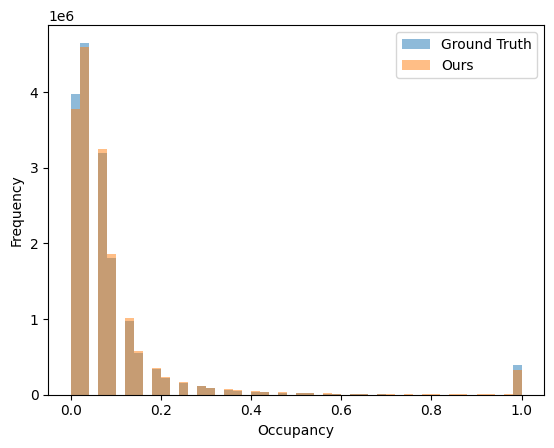

In [ ]:
DIM = 256
N = 32
def compute_occupancy_grid(scene, dim, nsamples):
    # Generate a 3D grid between [-1, 1]x[-1, 1]x[-1, 1]
    x = dr.linspace(mi.Float, -1, 1, dim)
    y = dr.linspace(mi.Float, -1, 1, dim)
    z = dr.linspace(mi.Float, -1, 1, dim)
    grid = dr.meshgrid(x, y, z)

    occupancy = dr.zeros(mi.Float, dr.shape(grid)[1])

    rng = dr.rng(seed=0)
    for i in range(nsamples):
        # Generate a ray spherical coordinate
        # Uniform on the sphere
        d = mi.warp.square_to_uniform_sphere(rng.uniform(mi.Point2f, (2, dr.shape(grid)[1])))

        # Generate a ray from the grid position to the d direction
        ray = mi.Ray3f(grid, d)
        is_intersect = scene.ray_test(ray)
        occupancy += dr.select(is_intersect, 1.0, 0.0)
    occupancy /= nsamples
    return grid, occupancy

grid, occupancy_gt = compute_occupancy_grid(scene_gt, DIM, N)
grid, occupancy_ours = compute_occupancy_grid(scene_ours, DIM, N)

# Print stats

# Show histogram
plt.hist(occupancy_gt.numpy().flatten(), bins=50, alpha=0.5, label='Ground Truth')
plt.hist(occupancy_ours.numpy().flatten(), bins=50, alpha=0.5, label='Ours')
plt.xlabel("Occupancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
def convert_np(grid, occupancy):
    # Convert drjit arrays to numpy arrays
    grid_np = dr.unravel(dr.llvm.ad.Array3f, dr.ravel(grid)).numpy()
    grid_np = np.swapaxes(grid_np, 0, 1)  # Swap axes to match Polyscope's expected format
    occupancy_np = occupancy.numpy()
    
    return grid_np, occupancy_np

grid_np, occupancy_gt_np = convert_np(grid, occupancy_gt)
grid_np, occupancy_ours_np = convert_np(grid, occupancy_ours)

# Compute the metric on the difference of occupancy binary masks
occupancy_gt_np_bin = (occupancy_gt_np > 0.5).astype(np.float32)
occupancy_ours_np_bin = (occupancy_ours_np > 0.5).astype(np.float32)

# Compute the metric on the difference of occupancy binary masks
metric = 1-(np.sum(np.abs(occupancy_gt_np_bin - occupancy_ours_np_bin)) / np.sum(occupancy_gt_np_bin))
print(metric)

# Filter point cloud for visualisation
grid_gt_np = grid_np[occupancy_gt_np > 0.9]
occupancy_gt_np = occupancy_gt_np[occupancy_gt_np > 0.9]
grid_ours_np = grid_np[occupancy_ours_np > 0.9]
occupancy_ours_np = occupancy_ours_np[occupancy_ours_np > 0.9]

ps.init()
ps_cloud_gt = ps.register_point_cloud("GT", grid_gt_np, radius=0.005)
ps_cloud_ours = ps.register_point_cloud("Ours", grid_ours_np, radius=0.005)
ps.show()

0.26584363


KeyboardInterrupt: 